In [1]:
# 1. Imports
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import optuna

# modeling
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from scipy.special import logit, expit
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit

# PyTorch for conversion model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# nfl pbp loader
import nfl_data_py as nfl

# reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# 2a. Download PBP (this can take a few minutes)
seasons = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]
print("Loading play-by-play for seasons:", seasons)
raw_pbp = nfl.import_pbp_data(seasons, downcast=False)  # returns a DataFrame (may be large)

print("Rows loaded:", raw_pbp.shape[0])
raw_pbp.head()

Loading play-by-play for seasons: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2024 done.
Rows loaded: 433940


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,was_pressure,route,defense_man_zone_type,defense_coverage_type,offense_names,defense_names,offense_positions,defense_positions,offense_numbers,defense_numbers
0,1.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def parse_weather(weather_str):
    """
    Parses a weather string into structured features:
        - temp_F: float
        - humidity: float (percentage)
        - wind_mph: float
        - wind_dir: str
        - conditions: str (general description, e.g., 'sunny', 'cloudy', etc.)
    """
    result = {
        "temp_F": None,
        "humidity": None,
        "wind_mph": None,
        "wind_dir": None,
        "conditions": None
    }
    
    if not isinstance(weather_str, str):
        return result
    
    lower_str = weather_str.lower()
    
    # Extract temperature
    temp_match = re.search(r'(\d+)\s*°?\s*f', lower_str)
    if temp_match:
        result['temp_F'] = float(temp_match.group(1))
    
    # Extract humidity
    hum_match = re.search(r'humidity[:\s]*(\d+)%', lower_str)
    if hum_match:
        result['humidity'] = float(hum_match.group(1))
    
    # Extract wind speed and direction
    wind_match = re.search(r'wind[:\s]*([nesw]+)\s*(\d+)\s*mph', lower_str)
    if wind_match:
        result['wind_dir'] = wind_match.group(1).upper()
        result['wind_mph'] = float(wind_match.group(2))
    
    # Extract general conditions
    conditions = []
    for cond in ['sunny', 'cloudy', 'clear', 'rain', 'snow', 'fog', 'drizzle', 'storm', 'windy']:
        if cond in lower_str:
            conditions.append(cond)
    if conditions:
        result['conditions'] = ','.join(conditions)
    
    return result


def deconstruct_weather(df, weather_col='weather'):
    """
    Adds structured weather columns to a DataFrame based on a weather string column.
    
    New columns added:
      - temp_F
      - humidity
      - wind_mph
      - wind_dir
      - conditions
    """
    weather_data = df[weather_col].apply(parse_weather)
    weather_df = pd.DataFrame(weather_data.tolist())
    df = pd.concat([df.reset_index(drop=True), weather_df], axis=1)
    
    # Fill missing wind speeds with 0
    df['wind_mph'] = df['wind_mph'].fillna(0)

    # Fill missing temperatures with 60°F
    df['temp_F'] = df['temp_F'].fillna(60)

    return df

In [4]:
cols_to_keep = ['play_type', 'season', 'home_wp_post', 'away_wp_post', 'weather', 'yardline_100', 'ydstogo',
               'game_seconds_remaining', 'half_seconds_remaining', 'posteam', 'defteam',
               'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'kick_distance', 'touchback',
                'return_yards', 'first_down', 'touchdown', 'temp_F', 'wind_mph', 'game_id', 'score_differential',
                'home_team', 'away_team', 'home_score', 'away_score', 'down', 'field_goal_result']

In [5]:
pbp = raw_pbp.copy()
pbp = pbp[pbp.play_type.isin(['punt', 'run', 'pass', 'field_goal'])]
pbp = deconstruct_weather(pbp)
pbp = pbp[pbp.penalty == 0]
pbp = pbp[cols_to_keep].copy()
pbp['fg_made'] = (pbp["field_goal_result"] == "made").astype(int)

In [6]:
def make_temporal_folds(df, season_col="season", min_train_seasons=3):
    """
    Expanding-window CV folds by season.
    Returns list of (train_idx, val_idx).
    """
    seasons = np.sort(df[season_col].unique())
    folds = []

    for i in range(min_train_seasons, len(seasons)):
        train_seasons = seasons[:i]
        val_season = seasons[i]

        train_idx = df[df[season_col].isin(train_seasons)].index
        val_idx = df[df[season_col] == val_season].index

        folds.append((train_idx, val_idx))

    return folds

In [7]:
# --- Drop rows missing home/away WP ---
wp_df = pbp.dropna(subset=["home_wp_post", "away_wp_post"]).copy()

# --- Define features ---
wp_df["score_time_ratio"] = wp_df["score_differential"].abs() / (wp_df["game_seconds_remaining"] + 1)
wp_features = [
    "yardline_100",
    "down",
    "ydstogo",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

# --- Define posteam WP target ---
wp_df["wp_target"] = np.where(
    wp_df["posteam"] == wp_df["home_team"],
    wp_df["home_wp_post"],
    wp_df["away_wp_post"]
)

wp_df = wp_df.reset_index(drop=True)

X_wp = wp_df[wp_features]
y_wp = wp_df["wp_target"]

# --- Clip target to avoid exact 0/1 ---
epsilon = 1e-6
y_wp_clipped = y_wp.clip(epsilon, 1 - epsilon).reset_index(drop=True)

# --- Monotone constraints (time variables unconstrained now) ---
monotone_constraints_dict = {
    "yardline_100": -1,               # closer to opponent endzone → WP ↑
    "down": -1,                       # higher down (worse) → WP ↓
    "ydstogo": -1,                    # more yards to go → WP ↓
    "score_differential": 1,          # lead → WP ↑
    "posteam_timeouts_remaining": 1,  # more TOs → WP ↑
    "defteam_timeouts_remaining": -1  # opponent TOs → WP ↓
}

wp_folds = make_temporal_folds(wp_df)

In [8]:
def wp_objective(trial):

    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.08),
        "n_estimators": trial.suggest_int("n_estimators", 200, 400),
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),
        "min_child_weight": trial.suggest_int("min_child_weight", 20, 100),
        "verbosity": 0,
        "monotone_constraints": monotone_constraints_dict,
    }

    rmses = []

    for train_idx, val_idx in wp_folds:
        X_train, X_val = X_wp.iloc[train_idx], X_wp.iloc[val_idx]
        y_train, y_val = y_wp_clipped.iloc[train_idx], y_wp_clipped.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            early_stopping_rounds=10,
            verbose=False
        )

        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds, squared=False)
        rmses.append(rmse)

    return np.mean(rmses)

In [9]:
wp_study = optuna.create_study(direction="minimize")
wp_study.optimize(wp_objective, n_trials=3)

[I 2026-01-02 16:35:22,754] A new study created in memory with name: no-name-2fd367f3-2a0f-4245-894a-ba3f885b7f7d
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for be

C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

In [10]:
best_params = wp_study.best_params
best_score = wp_study.best_value

print("Best CV RMSE:", best_score)
print("Best params:", best_params)

Best CV RMSE: 0.059918289618106156
Best params: {'max_depth': 4, 'learning_rate': 0.03796243603258935, 'n_estimators': 383, 'subsample': 0.7274586015463796, 'min_child_weight': 78}


In [11]:
# Add monotone constraints if not in params already
best_params["monotone_constraints"] = monotone_constraints_dict
best_params["verbosity"] = 0

wp_model = XGBRegressor(**best_params)
wp_model.fit(X_wp, y_wp_clipped)  # Train on full dataset


def predict_wp(state_df):
    """
    Returns win probability for the team with possession in state_df.
    All EWPs are reported from the perspective of the pre-play offensive team.
    Therefore:
        - Use predict_wp(...) if possession is retained
        - Use 1 - predict_wp(...) if possession flips
    """
    
    if "score_time_ratio" not in state_df:
        state_df["score_time_ratio"] = state_df["score_differential"].abs() / (state_df["game_seconds_remaining"] + 1)
    preds = wp_model.predict(state_df[wp_features])
    return np.clip(preds, 0.0, 1.0)

In [12]:
def wp_symmetric_adjust(state_df, predict_wp):
    # Predict from original perspective
    wp = predict_wp(state_df)

    # Create flipped states
    state_flipped = state_df.copy()
    state_flipped["score_differential"] *= -1
    state_flipped[["posteam_timeouts_remaining", "defteam_timeouts_remaining"]] = \
        state_flipped[["defteam_timeouts_remaining", "posteam_timeouts_remaining"]].values
    state_flipped["yardline_100"] = 100 - state_flipped["yardline_100"]
    state_flipped["score_time_ratio"] = state_df["score_time_ratio"]
    
    wp_flipped = predict_wp(state_flipped)

    # Symmetric adjustment
    wp_sym = 0.5 * (wp + (1 - wp_flipped))
    
    # Weighting
    sym_weighting = 0.20
    
    return (1 - sym_weighting) * wp + sym_weighting * wp_sym

In [13]:
def flip_possession(state):
    """
    Flip possession for WP prediction.
    Returns a new state dict from the perspective of the new posteam.
    """
    new_state = state.copy()
    # Negate score differential
    new_state["score_differential"] = -state["score_differential"]
    # Swap timeouts
    new_state["posteam_timeouts_remaining"] = state["defteam_timeouts_remaining"]
    new_state["defteam_timeouts_remaining"] = state["posteam_timeouts_remaining"]
       
    return new_state

In [14]:
# Create punt_df with only punt plays
punt_df = pbp[pbp.play_type == "punt"].dropna(subset=["kick_distance", "return_yards"]).copy()

# Compute net punt yardage: kick distance minus return yards, adjust for touchbacks (if available)
# Assuming touchback puts ball at 20-yard line
punt_df["net_punt"] = punt_df["kick_distance"] - punt_df["return_yards"]
punt_df.loc[punt_df["touchback"] == 1, "net_punt"] = punt_df["yardline_100"] - 20

# Reset index to avoid any issues
punt_df = punt_df.reset_index(drop=True)

# Make temporal folds based on seasons in punt_df
punt_folds = make_temporal_folds(punt_df, season_col="season", min_train_seasons=3)

# Features to predict net punt
punt_df["score_time_ratio"] = punt_df["score_differential"].abs() / (punt_df["game_seconds_remaining"] + 1)
punt_features = [
    "yardline_100", 
    "game_seconds_remaining", 
    "half_seconds_remaining",
    "score_differential",
    "score_time_ratio",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "temp_F",
    "wind_mph"
]

X_punt = punt_df[punt_features].values
y_punt = punt_df["net_punt"].values

X_scaler = StandardScaler()
X_punt_scaled = X_scaler.fit_transform(X_punt)

y_scaler = StandardScaler()
y_punt_scaled = y_scaler.fit_transform(y_punt.reshape(-1,1))

In [15]:
def punt_objective(trial):
    # Suggest hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
    epochs = 50  # you can tune this later

    rmses = []

    # Loop over temporal folds
    for train_idx, val_idx in punt_folds:
        # Prepare fold data
        X_train = torch.tensor(X_punt_scaled[train_idx], dtype=torch.float32)
        y_train = torch.tensor(y_punt_scaled[train_idx], dtype=torch.float32)
        X_val = torch.tensor(X_punt_scaled[val_idx], dtype=torch.float32)
        y_val = torch.tensor(y_punt_scaled[val_idx], dtype=torch.float32)

        input_dim = X_train.shape[1]

        # Build the network
        layers = []
        for i in range(n_layers):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_size, 1))
        # For regression, remove Sigmoid. Keep raw output
        model = nn.Sequential(*layers)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training loop
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val).item()
            rmses.append(np.sqrt(val_loss))  # RMSE for consistency

    # Return mean RMSE across folds
    return np.mean(rmses)

In [16]:
punt_study = optuna.create_study(direction="minimize")
punt_study.optimize(punt_objective, n_trials=3)

[I 2026-01-02 16:36:54,497] A new study created in memory with name: no-name-c550b988-ee90-4689-a1c9-a7c78665fa5b
[I 2026-01-02 16:37:03,587] Trial 0 finished with value: 0.9200140196975952 and parameters: {'n_layers': 3, 'hidden_size': 99, 'lr': 0.0009311725417808037, 'dropout': 0.3967395131199915}. Best is trial 0 with value: 0.9200140196975952.
[I 2026-01-02 16:37:10,142] Trial 1 finished with value: 0.9689714094575281 and parameters: {'n_layers': 3, 'hidden_size': 72, 'lr': 0.00013253137514775105, 'dropout': 0.22461174389717437}. Best is trial 0 with value: 0.9200140196975952.
[I 2026-01-02 16:37:12,915] Trial 2 finished with value: 0.9196665466521754 and parameters: {'n_layers': 3, 'hidden_size': 25, 'lr': 0.003105571182702007, 'dropout': 0.19496299758350494}. Best is trial 2 with value: 0.9196665466521754.


In [17]:
best_params = punt_study.best_params
best_score = punt_study.best_value
n_layers = best_params["n_layers"]
hidden_size = best_params["hidden_size"]
dropout_rate = best_params["dropout"]
lr = best_params["lr"]

print("Best CV RMSE:", best_score)
print("Best params:", best_params)

Best CV RMSE: 0.9196665466521754
Best params: {'n_layers': 3, 'hidden_size': 25, 'lr': 0.003105571182702007, 'dropout': 0.19496299758350494}


In [18]:
# Build final model
layers = []
input_dim = X_punt_scaled.shape[1]
for i in range(n_layers):
    layers.append(nn.Linear(input_dim if i==0 else hidden_size, hidden_size))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout_rate))
layers.append(nn.Linear(hidden_size, 1))
punt_model = nn.Sequential(*layers)

# Convert full data to tensors
X_t = torch.tensor(X_punt_scaled, dtype=torch.float32)
y_t = torch.tensor(y_punt_scaled, dtype=torch.float32)

optimizer = torch.optim.Adam(punt_model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# Train final model
epochs = 1000  # or tune
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = punt_model(X_t)
    loss = loss_fn(preds, y_t)
    loss.backward()
    optimizer.step()

In [19]:
def predict_punt(state_dict):
    """
    state_dict can be a DataFrame (multiple rows) or a Series (single row)
    """
    # Ensure 2D input
    if isinstance(state_dict, pd.Series):
        state_df = pd.DataFrame([state_dict])
    else:
        state_df = state_dict

    x_scaled = X_scaler.transform(state_df[punt_features])
    x_t = torch.tensor(x_scaled, dtype=torch.float32)

    with torch.no_grad():
        y_scaled_pred = punt_model(x_t).numpy().ravel()  # works for batch or single row

    net_punt = y_scaler.inverse_transform(y_scaled_pred.reshape(-1, 1)).ravel()

    # Return scalar if single row, else array
    if len(net_punt) == 1:
        return net_punt[0]
    return net_punt

In [20]:
# --- Filter to field goal attempts only ---
fg_df = pbp[pbp.play_type == "field_goal"].dropna(subset=["field_goal_result"]).copy()
fg_df = fg_df[fg_df.field_goal_result.isin(['made', 'missed', 'blocked'])]

# Field goal
fg_df["score_time_ratio"] = fg_df["score_differential"].abs() / (fg_df["game_seconds_remaining"] + 1)
fg_features = [
    "yardline_100",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

X_fg = fg_df[fg_features]
y_fg = fg_df["fg_made"]

fg_folds = make_temporal_folds(
    fg_df,
    season_col="season",
    min_train_seasons=3
)

fg_oof_pred = pd.Series(index=fg_df.index, dtype=float)
fg_df["fg_make_prob_oof"] = fg_oof_pred

for fold_num, (train_idx, val_idx) in enumerate(fg_folds, 1):
    X_train = X_fg.loc[train_idx]
    y_train = y_fg.loc[train_idx]
    X_val   = X_fg.loc[val_idx]

    fg_model_lr_fold = LogisticRegression(
        solver="lbfgs",
        max_iter=1000
    )

    fg_model_lr_fold.fit(X_train, y_train)

    fg_oof_pred.loc[val_idx] = fg_model_lr_fold.predict_proba(X_val)[:, 1]

fg_oof_rmse = np.sqrt(
    np.mean((fg_oof_pred.values - y_fg.values) ** 2)
)

mask = fg_oof_pred.notna()
fg_oof_rmse = np.sqrt(np.mean((fg_oof_pred[mask] - y_fg[mask]) ** 2))
print("FG (LogReg) OOF RMSE:", fg_oof_rmse)

fg_final_model = LogisticRegression(
    solver="lbfgs",
    max_iter=1000
)

fg_final_model.fit(X_fg, y_fg)

FG (LogReg) OOF RMSE: 0.34092530286213574


LogisticRegression(max_iter=1000)

In [21]:
max_fg = 65
fg_decay_threshold = 60

In [22]:
def predict_fg(state_dict):
    df = pd.DataFrame([state_dict])

    if "score_time_ratio" not in df:
        df["score_time_ratio"] = (
            df["score_differential"].abs()
            / (df["game_seconds_remaining"] + 1)
        )

    p_make = fg_final_model.predict_proba(df[fg_features])[:, 1][0]

    # Long-kick decay
    kick_distance = state_dict["kick_distance"]

    if kick_distance >= fg_decay_threshold:
        p_make *= max(
            0,
            (max_fg - kick_distance) / (max_fg - fg_decay_threshold)
        )

    return np.clip(p_make, 0.0, 1.0)

In [23]:
# Filter to 4th-down go-for-it plays
go_df = pbp[
    (pbp['down'] == 4) &
    (pbp['play_type'].isin(['run', 'pass']))  # filters out punts/FGs
].copy()

# Target: did the team convert?
go_df = go_df.dropna(subset=['first_down'])

# Go-for-it conversion
go_df["score_time_ratio"] = go_df["score_differential"].abs() / (go_df["game_seconds_remaining"] + 1)

go_df["success"] = (
    (go_df["first_down"] == 1) |
    (go_df["touchdown"] == 1)
).astype(int)

# Reset index to avoid any issues
go_df = go_df.reset_index(drop=True)

# Make temporal folds based on seasons in punt_df
go_folds = make_temporal_folds(go_df, season_col="season", min_train_seasons=3)

# Features to predict net punt
go_features = [
    "yardline_100",
    "ydstogo",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

X_go = go_df[go_features].values
y_go = go_df["success"].values

In [24]:
monotone_constraints = [
    -1,  # yardline_100 (farther → worse)
    -1,  # ydstogo (longer → worse)
    0,   # game_seconds_remaining
    0,   # half_seconds_remaining
    1,   # score_differential
    0,   # posteam_timeouts_remaining
    0,   # defteam_timeouts_remaining
    -1,  # score_time_ratio
    0,   # temp_F
    0    # wind_mph
]

def go_objective(trial):
    # Suggest hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "objective": "binary:logistic",
        "monotone_constraints": tuple(monotone_constraints),
        "eval_metric": "logloss",
        "use_label_encoder": False
    }

    log_losses = []

    for train_idx, val_idx in go_folds:
        X_train, X_val = X_go[train_idx], X_go[val_idx]  # no scaler
        y_train, y_val = y_go[train_idx], y_go[val_idx]

        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        preds = model.predict_proba(X_val)[:, 1]
        log_losses.append(log_loss(y_val, preds))

    return np.mean(log_losses)

In [25]:
# Run Optuna search
go_study = optuna.create_study(direction="minimize")
go_study.optimize(go_objective, n_trials=3)

[I 2026-01-02 16:37:27,410] A new study created in memory with name: no-name-7bff92c8-1929-4dd1-be70-e8643f3f77c4
[I 2026-01-02 16:38:27,745] Trial 0 finished with value: 0.6669056449271688 and parameters: {'max_depth': 10, 'learning_rate': 0.0010627187653207716, 'n_estimators': 444, 'subsample': 0.8660782360444272, 'colsample_bytree': 0.9400617152554533}. Best is trial 0 with value: 0.6669056449271688.
[I 2026-01-02 16:38:34,748] Trial 1 finished with value: 0.6743603392664602 and parameters: {'max_depth': 7, 'learning_rate': 0.0038748457393156487, 'n_estimators': 75, 'subsample': 0.9003972086862225, 'colsample_bytree': 0.9185975241436004}. Best is trial 0 with value: 0.6669056449271688.
[I 2026-01-02 16:38:45,065] Trial 2 finished with value: 0.6530223242143541 and parameters: {'max_depth': 4, 'learning_rate': 0.012346563361372418, 'n_estimators': 195, 'subsample': 0.5364162153460718, 'colsample_bytree': 0.743610910733187}. Best is trial 2 with value: 0.6530223242143541.


In [26]:
# Train final model with best hyperparameters
best_params = go_study.best_trial.params
best_params["monotone_constraints"] = tuple(monotone_constraints)
best_params["use_label_encoder"] = False
best_params["eval_metric"] = "logloss"

# Compute class imbalance weight
pos = (y_go == 1).sum()
neg = (y_go == 0).sum()
scale_pos_weight = neg / pos

conv_model = XGBClassifier(**best_params, scale_pos_weight=scale_pos_weight)
conv_model.fit(X_go, y_go)  # feed raw features, no scaling

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.743610910733187, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.012346563361372418,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan,
              monotone_constraints=(-1, -1, 0, 0, 1, 0, 0, -1, 0, 0),
              multi_strategy=None, n_estimators=195, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
def go_for_it_success_penalty(ydstogo, wp_current, game_seconds_remaining, alpha=0.01, c=3.5):
    """
    Bounded penalty applied to WP for long 4th-down attempts.
    """
    # --- Distance term
    dist_term = np.tanh((ydstogo - 6) / c)
    dist_term = np.maximum(0.0, dist_term)

    # --- WP weighting: strongest near wp_current = 0.5
    wp_weight = 1.0 - 4.0 * (wp_current - 0.5) ** 2
    wp_weight = np.clip(wp_weight, 0.0, 1.0)

    # --- Time weighting: fades late in game
    time_weight = np.minimum(1.0, game_seconds_remaining / 900.0)

    penalty = alpha * dist_term * wp_weight * time_weight
    return penalty

In [28]:
def scoring_possessions_to_tie(score_differential):
    """
    Returns the number of scoring possessions needed to tie.
    Works with a single scalar or a pandas Series/NumPy array.
    """
    if isinstance(score_differential, (pd.Series, np.ndarray)):
        score_diff = np.asarray(score_differential)
        # Example: 0 if score_diff >= 0, otherwise ceil(abs(score_diff)/7)
        return np.where(score_diff >= 0, 0, np.ceil(np.abs(score_diff)/7))
    else:
        # scalar case
        if score_differential >= 0:
            return 0
        return np.ceil(abs(score_differential)/7)

In [29]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

In [30]:
def required_margin_multiplier(yardline, score_differential, game_seconds_remaining):
    """
    Penalizes aggression as the team has a bigger lead, more time, or is deeper in their own territory.
    Returns a weight that multiplies raw aggression.
    """

    # --- Smooth score/time-based weight
    score_time_ratio = np.clip(score_differential / (game_seconds_remaining + 1), -1, 1)
    ratio_weight = sigmoid(3 * score_time_ratio) # ratio_weight ~ 0 when trailing, ~1 when leading
    
    # --- Yardline weight (higher in opponent territory → more aggressive, lower in own territory → less aggressive)
    yardline_weight = 0.5 + 0.5 * sigmoid(0.1 * yardline - 5)

    # --- Final aggression adjustment
    return (ratio_weight + 0.05 * score_differential) * yardline_weight

In [234]:
plays_df = pbp.copy()
plays_df['wp_pred'] = wp_symmetric_adjust(plays_df, predict_wp)

# Compute final scores and win from offensive team perspective
final_scores = (
    pbp.groupby("game_id")
       .tail(1)[["game_id","home_team","away_team","home_score","away_score"]]
       .copy()
)
final_scores["home_win"] = (final_scores["home_score"] > final_scores["away_score"]).astype(int)

plays_df = plays_df.merge(final_scores[["game_id","home_win"]], on="game_id", how="left")
plays_df["win_actual"] = np.where(
    plays_df["posteam"] == plays_df["home_team"],
    plays_df["home_win"],
    1 - plays_df["home_win"]
)

In [235]:
pbp_pre_computed = plays_df.copy()
pbp_pre_computed.loc[:, "score_time_ratio"] = (pbp_pre_computed["score_differential"].abs() / (pbp_pre_computed["game_seconds_remaining"] + 1))
pbp_pre_computed['scoring_possessions_to_tie'] = scoring_possessions_to_tie(pbp_pre_computed['score_differential'])
pbp_pre_computed['possessions_to_tie_boost'] = 0.1 / np.maximum(1, pbp_pre_computed['scoring_possessions_to_tie'])
pbp_pre_computed['wp_current'] = wp_symmetric_adjust(pbp_pre_computed[wp_features], predict_wp)
pbp_pre_computed['go_success_penalty'] = go_for_it_success_penalty(pbp_pre_computed['ydstogo'], pbp_pre_computed['wp_current'], pbp_pre_computed['game_seconds_remaining'], alpha=.035, c=3.5)

In [236]:
pbp_pre_computed['fg_success_yardline_100'] = 75
pbp_pre_computed['fg_success_down'] = 1
pbp_pre_computed['fg_success_ydstogo'] = 10
pbp_pre_computed['fg_success_game_seconds_remaining'] = np.maximum(0, pbp_pre_computed['game_seconds_remaining'] - 5)
pbp_pre_computed['fg_success_half_seconds_remaining'] = np.maximum(0, pbp_pre_computed['half_seconds_remaining'] - 5)
pbp_pre_computed['fg_success_score_differential'] = -(pbp_pre_computed['score_differential'] + 3)
pbp_pre_computed['fg_success_posteam_timeouts_remaining'] = pbp_pre_computed['defteam_timeouts_remaining']
pbp_pre_computed['fg_success_defteam_timeouts_remaining'] = pbp_pre_computed['posteam_timeouts_remaining']
pbp_pre_computed['fg_success_score_time_ratio'] = pbp_pre_computed['fg_success_score_differential'].abs() / (pbp_pre_computed['fg_success_game_seconds_remaining'] + 1)
pbp_pre_computed['fg_success_temp_F'] = pbp_pre_computed['temp_F']
pbp_pre_computed['fg_success_wind_mph'] = pbp_pre_computed['wind_mph']

pbp_pre_computed['fg_fail_yardline_100'] = 100 - (pbp_pre_computed['yardline_100'] + 7)
pbp_pre_computed['fg_fail_down'] = 1
pbp_pre_computed['fg_fail_ydstogo'] = 10
pbp_pre_computed['fg_fail_game_seconds_remaining'] = np.maximum(0, pbp_pre_computed['game_seconds_remaining'] - 5)
pbp_pre_computed['fg_fail_half_seconds_remaining'] = np.maximum(0, pbp_pre_computed['half_seconds_remaining'] - 5)
pbp_pre_computed['fg_fail_score_differential'] = -pbp_pre_computed['score_differential']
pbp_pre_computed['fg_fail_posteam_timeouts_remaining'] = pbp_pre_computed['defteam_timeouts_remaining']
pbp_pre_computed['fg_fail_defteam_timeouts_remaining'] = pbp_pre_computed['posteam_timeouts_remaining']
pbp_pre_computed['fg_fail_score_time_ratio'] = pbp_pre_computed['fg_fail_score_differential'].abs() / (pbp_pre_computed['fg_fail_game_seconds_remaining'] + 1)
pbp_pre_computed['fg_fail_temp_F'] = pbp_pre_computed['temp_F']
pbp_pre_computed['fg_fail_wind_mph'] = pbp_pre_computed['wind_mph']

pbp_pre_computed['go_success_yardline_100'] = pbp_pre_computed['yardline_100'] - pbp_pre_computed['ydstogo']
pbp_pre_computed['go_success_down'] = 1
pbp_pre_computed['go_success_ydstogo'] = np.minimum(10, pbp_pre_computed['go_success_yardline_100'])
pbp_pre_computed['go_success_game_seconds_remaining'] = np.maximum(0, pbp_pre_computed['game_seconds_remaining'] - 5)
pbp_pre_computed['go_success_half_seconds_remaining'] = np.maximum(0, pbp_pre_computed['half_seconds_remaining'] - 5)
pbp_pre_computed['go_success_score_differential'] = pbp_pre_computed['score_differential']
pbp_pre_computed['go_success_posteam_timeouts_remaining'] = pbp_pre_computed['posteam_timeouts_remaining']
pbp_pre_computed['go_success_defteam_timeouts_remaining'] = pbp_pre_computed['defteam_timeouts_remaining']
pbp_pre_computed['go_success_score_time_ratio'] = pbp_pre_computed['go_success_score_differential'].abs() / (pbp_pre_computed['go_success_game_seconds_remaining'] + 1)
pbp_pre_computed['go_success_temp_F'] = pbp_pre_computed['temp_F']
pbp_pre_computed['go_success_wind_mph'] = pbp_pre_computed['wind_mph']

pbp_pre_computed['go_fail_yardline_100'] = 100 - pbp_pre_computed['yardline_100']
pbp_pre_computed['go_fail_down'] = 1
pbp_pre_computed['go_fail_ydstogo'] = 10
pbp_pre_computed['go_fail_game_seconds_remaining'] = np.maximum(0, pbp_pre_computed['game_seconds_remaining'] - 5)
pbp_pre_computed['go_fail_half_seconds_remaining'] = np.maximum(0, pbp_pre_computed['half_seconds_remaining'] - 5)
pbp_pre_computed['go_fail_score_differential'] = -pbp_pre_computed['score_differential']
pbp_pre_computed['go_fail_posteam_timeouts_remaining'] = pbp_pre_computed['defteam_timeouts_remaining']
pbp_pre_computed['go_fail_defteam_timeouts_remaining'] = pbp_pre_computed['posteam_timeouts_remaining']
pbp_pre_computed['go_fail_score_time_ratio'] = pbp_pre_computed['go_fail_score_differential'].abs() / (pbp_pre_computed['go_fail_game_seconds_remaining'] + 1)
pbp_pre_computed['go_fail_temp_F'] = pbp_pre_computed['temp_F']
pbp_pre_computed['go_fail_wind_mph'] = pbp_pre_computed['wind_mph']

In [237]:
fourth_down_mask = pbp_pre_computed["down"] == 4

X_fg_success = pbp_pre_computed.loc[fourth_down_mask, [
    "fg_success_yardline_100",
    "fg_success_down",
    "fg_success_ydstogo",
    "fg_success_game_seconds_remaining",
    "fg_success_half_seconds_remaining",
    "fg_success_score_differential",
    "fg_success_posteam_timeouts_remaining",
    "fg_success_defteam_timeouts_remaining",
    "fg_success_score_time_ratio",
    "fg_success_temp_F",
    "fg_success_wind_mph"
]].copy()

X_fg_success.columns = wp_features

X_fg_fail = pbp_pre_computed.loc[fourth_down_mask, [
    "fg_fail_yardline_100",
    "fg_fail_down",
    "fg_fail_ydstogo",
    "fg_fail_game_seconds_remaining",
    "fg_fail_half_seconds_remaining",
    "fg_fail_score_differential",
    "fg_fail_posteam_timeouts_remaining",
    "fg_fail_defteam_timeouts_remaining",
    "fg_fail_score_time_ratio",
    "fg_fail_temp_F",
    "fg_fail_wind_mph"
]].copy()

X_fg_fail.columns = wp_features

In [238]:
wp_fg_success = 1 - wp_symmetric_adjust(X_fg_success, predict_wp)
wp_fg_fail = 1 - wp_symmetric_adjust(X_fg_fail, predict_wp)

# Predict FG make probability using current state
X_fg_current = pbp_pre_computed.loc[fourth_down_mask, fg_features]
p_make = fg_final_model.predict_proba(X_fg_current)[:, 1]
yardlines = X_fg_current['yardline_100']
p_make_decayed = np.where(yardlines >= (fg_decay_threshold - 17), p_make * np.maximum(0, (max_fg - 17 - yardlines) / (max_fg - fg_decay_threshold)), p_make)

# Compute expected WP for FG attempt
ewp_fg = np.full(len(pbp_pre_computed), np.nan)
ewp_fg[fourth_down_mask] = np.clip(p_make_decayed * wp_fg_success + (1 - p_make_decayed) * wp_fg_fail, 0, 1)

wp_fg_success_array = np.full(len(pbp_pre_computed), np.nan)
wp_fg_success_array[fourth_down_mask] = wp_fg_success

wp_fg_fail_array = np.full(len(pbp_pre_computed), np.nan)
wp_fg_fail_array[fourth_down_mask] = wp_fg_fail

# Save to DataFrame
pbp_pre_computed["ewp_fg"] = ewp_fg
pbp_pre_computed['wp_fg_success'] = wp_fg_success_array
pbp_pre_computed['wp_fg_fail'] = wp_fg_fail_array
pbp_pre_computed["p_make_fg"] = 0
pbp_pre_computed.loc[fourth_down_mask, "p_make_fg"] = p_make_decayed

In [239]:
X_go_success = pbp_pre_computed.loc[fourth_down_mask, [
    "go_success_yardline_100",
    "go_success_down",
    "go_success_ydstogo",
    "go_success_game_seconds_remaining",
    "go_success_half_seconds_remaining",
    "go_success_score_differential",
    "go_success_posteam_timeouts_remaining",
    "go_success_defteam_timeouts_remaining",
    "go_success_score_time_ratio",
    "go_success_temp_F",
    "go_success_wind_mph"
]].copy()

X_go_success.columns = wp_features

X_go_fail = pbp_pre_computed.loc[fourth_down_mask, [
    "go_fail_yardline_100",
    "go_fail_down",
    "go_fail_ydstogo",
    "go_fail_game_seconds_remaining",
    "go_fail_half_seconds_remaining",
    "go_fail_score_differential",
    "go_fail_posteam_timeouts_remaining",
    "go_fail_defteam_timeouts_remaining",
    "go_fail_score_time_ratio",
    "go_fail_temp_F",
    "go_fail_wind_mph"
]].copy()

X_go_fail.columns = wp_features

In [240]:
masked_discrete_possessions_boost = pbp_pre_computed.loc[fourth_down_mask, "possessions_to_tie_boost"]
wp_go_success = wp_symmetric_adjust(X_go_success, predict_wp)
wp_go_success = np.clip(wp_go_success + masked_discrete_possessions_boost, 0, 1)
wp_go_fail = 1 - wp_symmetric_adjust(X_go_fail, predict_wp)

# Predict FG make probability using current state
X_go_current = pbp_pre_computed.loc[fourth_down_mask, go_features]
p_convert = conv_model.predict_proba(X_go_current)[:, 1]

# Compute expected WP for FG attempt
ewp_go = np.full(len(pbp_pre_computed), np.nan)
ewp_go[fourth_down_mask] = p_convert * wp_go_success + (1 - p_convert) * wp_go_fail

wp_go_success_array = np.full(len(pbp_pre_computed), np.nan)
wp_go_success_array[fourth_down_mask] = wp_go_success
pbp_pre_computed['wp_go_success'] = wp_go_success_array

wp_go_fail_array = np.full(len(pbp_pre_computed), np.nan)
wp_go_fail_array[fourth_down_mask] = wp_go_fail
pbp_pre_computed['wp_go_fail'] = wp_go_fail_array

# Save to DataFrame
pbp_pre_computed["ewp_go"] = ewp_go
pbp_pre_computed['ewp_go_adj'] = np.clip(pbp_pre_computed['ewp_go'] - pbp_pre_computed['go_success_penalty'], 0, 1)
pbp_pre_computed["p_convert"] = 0
pbp_pre_computed.loc[fourth_down_mask, "p_convert"] = p_convert

In [241]:
X_punt_current = pbp_pre_computed.loc[fourth_down_mask, punt_features]

# 1. Pandas → numpy
X_punt_np = X_punt_current.values.astype(np.float32)

# 2. Scale inputs
X_punt_np_scaled = X_scaler.transform(X_punt_np)

# 3. numpy → torch
X_punt_tensor = torch.tensor(X_punt_np_scaled, dtype=torch.float32)

# 4. Predict (scaled output)
punt_model.eval()
with torch.no_grad():
    y_scaled_pred = punt_model(X_punt_tensor).squeeze().cpu().numpy()

# 5. Inverse transform target
punt_pred_yards = y_scaler.inverse_transform(
    y_scaled_pred.reshape(-1, 1)
).ravel()

punt_preds = np.zeros(len(pbp_pre_computed))
punt_preds[fourth_down_mask] = punt_pred_yards

In [242]:
pbp_pre_computed['punt_pred_yards'] = punt_preds
 
landing_kicking = pbp_pre_computed['yardline_100'] - pbp_pre_computed['punt_pred_yards']
landing_kicking = np.where(landing_kicking < 0, 20, landing_kicking)  # Only clip beyond goal line
pbp_pre_computed['post_punt_yardline_100'] = 100 - landing_kicking # Flip possession

pbp_pre_computed['post_punt_down'] = 1
pbp_pre_computed['post_punt_ydstogo'] = 10
pbp_pre_computed['post_punt_game_seconds_remaining'] = np.maximum(0, pbp_pre_computed['game_seconds_remaining'] - 8)
pbp_pre_computed['post_punt_half_seconds_remaining'] = np.maximum(0, pbp_pre_computed['half_seconds_remaining'] - 8)
pbp_pre_computed['post_punt_score_differential'] = -pbp_pre_computed['score_differential']
pbp_pre_computed['post_punt_posteam_timeouts_remaining'] = pbp_pre_computed['defteam_timeouts_remaining']
pbp_pre_computed['post_punt_defteam_timeouts_remaining'] = pbp_pre_computed['posteam_timeouts_remaining']
pbp_pre_computed['post_punt_score_time_ratio'] = pbp_pre_computed['post_punt_score_differential'].abs() / (pbp_pre_computed['post_punt_game_seconds_remaining'] + 1)
pbp_pre_computed['post_punt_temp_F'] = pbp_pre_computed['temp_F']
pbp_pre_computed['post_punt_wind_mph'] = pbp_pre_computed['wind_mph']

In [243]:
X_post_punt = pbp_pre_computed.loc[fourth_down_mask, [
    "post_punt_yardline_100",
    "post_punt_down",
    "post_punt_ydstogo",
    "post_punt_game_seconds_remaining",
    "post_punt_half_seconds_remaining",
    "post_punt_score_differential",
    "post_punt_posteam_timeouts_remaining",
    "post_punt_defteam_timeouts_remaining",
    "post_punt_score_time_ratio",
    "post_punt_temp_F",
    "post_punt_wind_mph"
]].copy()

X_post_punt.columns = wp_features

In [244]:
wp_post_punt = 1 - wp_symmetric_adjust(X_post_punt, predict_wp)

# Compute expected WP for FG attempt
ewp_punt = np.full(len(pbp_pre_computed), np.nan)
ewp_punt[fourth_down_mask] = wp_post_punt

# Save to DataFrame
pbp_pre_computed["ewp_punt"] = ewp_punt

In [245]:
# Map play_type → EWP column
action_to_col = {
    "punt": "ewp_punt",
    "field_goal": "ewp_fg",
    "run": "ewp_go_adj",
    "pass": "ewp_go_adj"
}
pbp_pre_computed["actual_col"] = pbp_pre_computed["play_type"].map(action_to_col)

# EWP columns
ewp_cols = ["ewp_go_adj", "ewp_fg", "ewp_punt"]

# Compute actual EWP for each row
col_idx = pbp_pre_computed[["actual_col"]].apply(lambda x: pbp_pre_computed.columns.get_loc(x[0]), axis=1).to_numpy()
row_idx = np.arange(len(pbp_pre_computed))
pbp_pre_computed["ewp_actual"] = pbp_pre_computed.to_numpy()[row_idx, col_idx]

# Compute best EWP and regret
pbp_pre_computed["ewp_best"] = pbp_pre_computed[ewp_cols].max(axis=1)
pbp_pre_computed["regret_actual"] = pbp_pre_computed["ewp_best"] - pbp_pre_computed["ewp_actual"]

# Compute decision margin (difference between top two EWP values)
ewp_sorted = np.sort(pbp_pre_computed[ewp_cols].values, axis=1)
pbp_pre_computed["decision_margin"] = ewp_sorted[:, -1] - ewp_sorted[:, -2]

In [246]:
# Regret vs Decision Margin when coach disagrees
# Map best EWP column to recommended play
col_to_action = {
    "ewp_punt": "punt",
    "ewp_fg": "field_goal",
    "ewp_go_adj": "go"
}
pbp_pre_computed["recommended_play"] = pbp_pre_computed[ewp_cols].idxmax(axis=1).map(col_to_action)

# Identify disagreement
pbp_pre_computed["disagreed"] = ~(
    ((pbp_pre_computed.play_type == "punt") & (pbp_pre_computed.recommended_play == "punt")) |
    ((pbp_pre_computed.play_type == "field_goal") & (pbp_pre_computed.recommended_play == "field_goal")) |
    ((pbp_pre_computed.play_type.isin(["run", "pass"])) & (pbp_pre_computed.recommended_play == "go"))
)

# Follow model rate vs Decision Margin
pbp_pre_computed["best_col"] = pbp_pre_computed[ewp_cols].idxmax(axis=1)
pbp_pre_computed["follow_model"] = (pbp_pre_computed["actual_col"] == pbp_pre_computed["best_col"]).astype(int)

In [247]:
pbp_fourth = pbp_pre_computed[pbp_pre_computed.down == 4].copy()

In [248]:
def evaluate_punt(state):
    """
    Evaluate a punt attempt.
    Returns expected WP for the punting team after the punt.
    """
    df = pd.DataFrame([state])
    wp_current = wp_symmetric_adjust(df, predict_wp)[0]

    # Predict net punt
    net_punt = predict_punt(df[punt_features])

    # Compute receiving team's field position
    if net_punt >= state["yardline_100"]:
        new_yardline_100 = 80  # Touchback → opponent at own 20
    else:
        new_yardline_100 = 100 - (state["yardline_100"] - net_punt)

    # Construct post-punt state for opponent
    punt_result_state = state.copy()
    punt_result_state["yardline_100"] = new_yardline_100
    punt_result_state["down"] = 1
    punt_result_state["ydstogo"] = 10

    # Flip possession
    punt_result_state_flipped = flip_possession(punt_result_state)
    punt_result_state_flipped['half_seconds_remaining'] = max(0, punt_result_state_flipped['half_seconds_remaining'] - 8)
    punt_result_state_flipped['game_seconds_remaining'] = max(0, punt_result_state_flipped['game_seconds_remaining'] - 8)
    punt_result_state_flipped["score_time_ratio"] = abs(punt_result_state_flipped["score_differential"]) / (punt_result_state_flipped["game_seconds_remaining"] + 1)
    
    # Opponent WP
    wp_opponent = wp_symmetric_adjust(pd.DataFrame([punt_result_state_flipped]), predict_wp)[0]

    # Punting team's expected WP
    ewp_punt = 1 - wp_opponent
    
    # Account for late-game scenario
    if state['score_differential'] <= -1:
        # Assume each timeout saves 42 seconds
        if state['game_seconds_remaining'] <= 42 * (3 - state['posteam_timeouts_remaining']):
                ewp_punt = 0

    return {
        "wp_current": round(wp_current, 4),
        "net_punt": round(net_punt, 4),
        "ewp_punt": round(ewp_punt, 4)
    }

In [249]:
def evaluate_field_goal(state):
    """Evaluates a field goal attempt."""
    df = pd.DataFrame([state])
    wp_current = wp_symmetric_adjust(df, predict_wp)[0]
    
    fg_state = state.copy()
    fg_state['kick_distance'] = fg_state['yardline_100'] + 17

    # Predict FG make probability
    p_make = predict_fg(fg_state)

    # State after successful FG
    fg_success_state = state.copy()
    fg_success_state["down"] = 1
    fg_success_state["ydstogo"] = 10
    fg_success_state['yardline_100'] = 75
    fg_success_state["score_differential"] += 3
    fg_success_state = flip_possession(fg_success_state)
    fg_success_state['half_seconds_remaining'] = max(0, fg_success_state['half_seconds_remaining'] - 5)
    fg_success_state['game_seconds_remaining'] = max(0, fg_success_state['game_seconds_remaining'] - 5)
    fg_success_state["score_time_ratio"] = abs(fg_success_state["score_differential"]) / (fg_success_state["game_seconds_remaining"] + 1)
    wp_success = 1 - predict_wp(pd.DataFrame([fg_success_state]))[0]

    # State after missed FG (opponent gets ball)
    fg_fail_state = state.copy()
    fg_fail_state["down"] = 1
    fg_fail_state["ydstogo"] = 10
    fg_fail_state["yardline_100"] = 100 - (state["yardline_100"] + 7)
    fg_fail_state = flip_possession(fg_fail_state)
    fg_fail_state['half_seconds_remaining'] = max(0, fg_fail_state['half_seconds_remaining'] - 5)
    fg_fail_state['game_seconds_remaining'] = max(0, fg_fail_state['game_seconds_remaining'] - 5)
    fg_fail_state["score_time_ratio"] = abs(fg_fail_state["score_differential"]) / (fg_fail_state["game_seconds_remaining"] + 1)
    wp_fail_for_us = 1 - wp_symmetric_adjust(pd.DataFrame([fg_fail_state]), predict_wp)[0]
    
    # Account for late-game scenario
    if state['score_differential'] <= -4:
        # Assume each timeout saves 42 seconds
        if state['game_seconds_remaining'] <= 42 * (3 - state['posteam_timeouts_remaining']):
                wp_success = 0
                wp_fail_for_us = 0
    
    # Expected WP
    ewp_field_goal = p_make * wp_success + (1 - p_make) * wp_fail_for_us

    return {
        "wp_current": round(wp_current,4),
        "p_make": round(p_make,4),
        "wp_success": round(wp_success,4),
        "wp_fail": round(wp_fail_for_us,4),
        "ewp_field_goal": round(ewp_field_goal,4)
    }

In [250]:
def evaluate_go_for_it(state):
    """Evaluates a 4th down go-for-it attempt with bounded boost and sensible penalty."""
    df = pd.DataFrame([state])
    wp_current = wp_symmetric_adjust(df, predict_wp)[0]

    # Conversion probability
    p_conv = conv_model.predict_proba(df[go_features])[:, 1][0]

    # --- WP if conversion succeeds
    go_success_state = state.copy()
    go_success_state["down"] = 1
    go_success_state["yardline_100"] = np.maximum(1, state["yardline_100"] - state['ydstogo'])
    go_success_state['ydstogo'] = np.minimum(10, go_success_state['yardline_100'])  # Account for 1st & goal
    go_success_state['half_seconds_remaining'] = np.maximum(0, go_success_state['half_seconds_remaining'] - 5)
    go_success_state['game_seconds_remaining'] = np.maximum(0, go_success_state['game_seconds_remaining'] - 5)
    go_success_state["score_time_ratio"] = abs(go_success_state["score_differential"]) / (go_success_state["game_seconds_remaining"] + 1)
    wp_success = np.clip(predict_wp(pd.DataFrame([go_success_state]))[0], 0, 1)

    # --- WP if conversion fails
    go_fail_state = state.copy()
    go_fail_state["down"] = 1
    go_fail_state["ydstogo"] = 10
    go_fail_state["yardline_100"] = 100 - state["yardline_100"]
    go_fail_state = flip_possession(go_fail_state)
    go_fail_state['half_seconds_remaining'] = np.maximum(0, go_fail_state['half_seconds_remaining'] - 5)
    go_fail_state['game_seconds_remaining'] = np.maximum(0, go_fail_state['game_seconds_remaining'] - 5)
    go_fail_state["score_time_ratio"] = abs(go_fail_state["score_differential"]) / (go_fail_state["game_seconds_remaining"] + 1)
    wp_fail_for_us = np.clip(1 - wp_symmetric_adjust(pd.DataFrame([go_fail_state]), predict_wp)[0], 0, 1)

    # --- Conditional success adjustment: small bounded boost
    possessions_to_tie = scoring_possessions_to_tie(state['score_differential'])
    discrete_possessions_boost = 0.1 / max(1, possessions_to_tie)  # max boost = 0.1, inversely proportional to possessions
    wp_success = np.clip(wp_success + discrete_possessions_boost, 0, 1)

    # --- Expected WP
    ewp_go_for_it = p_conv * wp_success + (1 - p_conv) * wp_fail_for_us

    # --- Apply penalty
    penalty = go_for_it_success_penalty(
        ydstogo=state["ydstogo"],
        wp_current=wp_current,
        game_seconds_remaining=state["game_seconds_remaining"],
        alpha=0.035,
        c=3.5
    )
    ewp_go_for_it_adj = np.clip(ewp_go_for_it - penalty, 0, 1)

    return {
        "wp_current": round(wp_current, 4),
        "p_conv": round(p_conv, 4),
        "wp_success": round(wp_success, 4),
        "wp_fail": round(wp_fail_for_us, 4),
        "ewp_go_for_it": round(ewp_go_for_it, 4),
        "ewp_go_for_it_adj": round(ewp_go_for_it_adj, 4)
    }

In [251]:
def evaluate_play_options(state):
    """Evaluates all 3 options on a 4th down."""
    # WP from current state
    wp_current = wp_symmetric_adjust(pd.DataFrame([state]), predict_wp)[0]

    # Evaluate each option
    punt_result = evaluate_punt(state)
    fg_result = evaluate_field_goal(state)
    go_result = evaluate_go_for_it(state)
    
    # Compute raw EWPs
    ewp_punt = punt_result["ewp_punt"]
    ewp_field_goal = fg_result["ewp_field_goal"]
    ewp_go_raw = go_result["ewp_go_for_it"]
    ewp_go_adj = go_result["ewp_go_for_it_adj"]
    
    # Compute WPAs
    wpa_punt = ewp_punt - wp_current
    wpa_field_goal = ewp_field_goal - wp_current
    wpa_go_for_it = ewp_go_adj - wp_current
    
    # Best conservative option
    best_conservative = max(ewp_punt, ewp_field_goal)

    # Raw go-for-it edge
    aggression_edge = ewp_go_adj - best_conservative

    # Contextual margin requirement
    strength = 0.03  # smaller now — acts as a threshold, not a tax
    required_margin = strength * required_margin_multiplier(
        state["yardline_100"],
        state["score_differential"],
        state["game_seconds_remaining"]
    )

    # Decision gating (NO EWP distortion)
    if aggression_edge > required_margin:
        recommended_play = "go_for_it"
    else:
        recommended_play = (
            "punt" if ewp_punt >= ewp_field_goal else "field_goal"
        )

    # Consolidate results
    results = {
        "wp_current": round(wp_current, 4),
        "ewp_punt": round(ewp_punt, 4),
        "ewp_field_goal": round(ewp_field_goal, 4),
        "ewp_go_raw": round(ewp_go_raw, 4),
        "ewp_go_adj": round(ewp_go_adj, 4),
        "required_margin": round(required_margin, 4),
        "wpa_punt": round(wpa_punt, 4),
        "wpa_field_goal": round(wpa_field_goal, 4),
        "wpa_go_for_it": round(wpa_go_for_it, 4),
        "recommended_play": recommended_play
    }

    return results

In [252]:
state = {
    "yardline_100": 31,             
    "down": 4,
    "ydstogo": 1,                   
    "game_seconds_remaining": 1870,   
    "half_seconds_remaining": 70,
    "score_differential": -7,       
    "posteam_timeouts_remaining": 3,
    "defteam_timeouts_remaining": 0,
    "temp_F" : 60,
    "wind_mph" : 0
}

evaluate_play_options(state)

{'wp_current': 0.3345,
 'ewp_punt': 0.2939,
 'ewp_field_goal': 0.3234,
 'ewp_go_raw': 0.3976,
 'ewp_go_adj': 0.3976,
 'required_margin': 0.0025,
 'wpa_punt': -0.0406,
 'wpa_field_goal': -0.0111,
 'wpa_go_for_it': 0.0631,
 'recommended_play': 'go_for_it'}

In [253]:
evaluate_punt(state)

{'wp_current': 0.3345, 'net_punt': 26.9998, 'ewp_punt': 0.2939}

In [254]:
evaluate_field_goal(state)

{'wp_current': 0.3345,
 'p_make': 0.7409,
 'wp_success': 0.3523,
 'wp_fail': 0.2409,
 'ewp_field_goal': 0.3234}

In [255]:
evaluate_go_for_it(state)

{'wp_current': 0.3345,
 'p_conv': 0.6094,
 'wp_success': 0.4905,
 'wp_fail': 0.2527,
 'ewp_go_for_it': 0.3976,
 'ewp_go_for_it_adj': 0.3976}

In [256]:
action_order = {
    "go_for_it": 2,
    "field_goal": 1,
    "punt": 0
}

def sweep_state(
    base_state,
    sweep_var,
    sweep_values,
    evaluate_fn=evaluate_play_options
):
    """
    Sweeps one variable while holding others fixed.
    Returns a list of dicts with state, EWPs, and decision.
    """
    results = []

    for v in sweep_values:
        state = base_state.copy()
        state[sweep_var] = v

        out = evaluate_fn(state)

        results.append({
            sweep_var: v,
            "recommended_play": out["recommended_play"],
            "action_score": action_order[out["recommended_play"]],
            "ewp_punt": out["ewp_punt"],
            "ewp_field_goal": out["ewp_field_goal"],
            "ewp_go_for_it": out["ewp_go_adj"],
        })

    return pd.DataFrame(results)


def detect_monotonicity_violations(df, aggression_is_decreasing):
    """
    Detects non-monotonic reversals in action_score and
    records the delta in EWP of the recommended play across the violation.
    """
    scores = df["action_score"].values

    violations = []
    delta_ewps = []

    for i in range(1, len(scores)):
        violation = False

        if aggression_is_decreasing:
            violation = scores[i] > scores[i - 1]
        else:
            violation = scores[i] < scores[i - 1]

        if violation:
            violations.append((i - 1, i))

            # Identify recommended play for each row
            recommended_prev = df.loc[i - 1, "recommended_play"]
            recommended_curr = df.loc[i, "recommended_play"]

            ewp_prev = df.loc[i - 1, f"ewp_{recommended_prev}"]
            ewp_curr = df.loc[i, f"ewp_{recommended_curr}"]

            delta_ewps.append(abs(ewp_curr - ewp_prev))

    return violations, delta_ewps


def describe_violations(df, violations, sweep_var):
    for i, j in violations:
        row_i = df.iloc[i]
        row_j = df.iloc[j]
        print(
            f"{sweep_var}: {row_i[sweep_var]} → {row_j[sweep_var]} | "
            f"{row_i['recommended_play']} → {row_j['recommended_play']}"
        )
        
        
def detect_monotonicity_behavior(base_state, sweep_var, sweep_range, aggression_is_decreasing):
    
    df = sweep_state(base_state, sweep_var, sweep_range)
    violations, delta_ewps = detect_monotonicity_violations(df, aggression_is_decreasing)
    describe_violations(df, violations, sweep_var)
    
    return df, violations, delta_ewps

In [257]:
monotonic_tests = [
    # As score_differential gets more positive, aggression should decrease
    ("score_differential", range(-14, 15), True),

    # As yards to go increases, aggression should decrease
    ("ydstogo", range(1, 11), True),

    # As yardline_100 increases (team is deeper in their own territory), aggression should decrease
    ("yardline_100", range(10, 90), True)
]

base_states = [
    # Early game, neutral score
    {"yardline_100": 30, "down": 4, "ydstogo": 3, "game_seconds_remaining": 1800, "half_seconds_remaining": 1800, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 60, "wind_mph": 0},

    # Late game, trailing
    {"yardline_100": 40, "down": 4, "ydstogo": 2, "game_seconds_remaining": 120, "half_seconds_remaining": 120, "score_differential": -7, "posteam_timeouts_remaining": 1, "defteam_timeouts_remaining": 2, "temp_F": 70, "wind_mph": 5},

    # Late game, leading
    {"yardline_100": 25, "down": 4, "ydstogo": 1, "game_seconds_remaining": 180, "half_seconds_remaining": 180, "score_differential": 10, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 1, "temp_F": 65, "wind_mph": 0},

    # Goal-to-go, short distance
    {"yardline_100": 5, "down": 4, "ydstogo": 1, "game_seconds_remaining": 600, "half_seconds_remaining": 600, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 55, "wind_mph": 0},

    # Goal-to-go, longer distance
    {"yardline_100": 3, "down": 4, "ydstogo": 4, "game_seconds_remaining": 900, "half_seconds_remaining": 900, "score_differential": -3, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 2, "temp_F": 60, "wind_mph": 0},

    # Midfield, short distance
    {"yardline_100": 50, "down": 4, "ydstogo": 1, "game_seconds_remaining": 900, "half_seconds_remaining": 900, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 60, "wind_mph": 0},

    # Midfield, long distance
    {"yardline_100": 50, "down": 4, "ydstogo": 8, "game_seconds_remaining": 1200, "half_seconds_remaining": 1200, "score_differential": -3, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 2, "temp_F": 60, "wind_mph": 0},

    # Own 40 yardline, moderate distance
    {"yardline_100": 60, "down": 4, "ydstogo": 5, "game_seconds_remaining": 1500, "half_seconds_remaining": 1500, "score_differential": 3, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 65, "wind_mph": 0},

    # Opponent 40 yardline, moderate distance
    {"yardline_100": 40, "down": 4, "ydstogo": 5, "game_seconds_remaining": 1500, "half_seconds_remaining": 1500, "score_differential": -3, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 65, "wind_mph": 0},

    # Neutral field, long distance, early game
    {"yardline_100": 50, "down": 4, "ydstogo": 10, "game_seconds_remaining": 1800, "half_seconds_remaining": 1800, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 60, "wind_mph": 0},

    # Own red zone, trailing
    {"yardline_100": 10, "down": 4, "ydstogo": 2, "game_seconds_remaining": 300, "half_seconds_remaining": 300, "score_differential": -4, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 3, "temp_F": 55, "wind_mph": 0},

    # Opponent red zone, leading
    {"yardline_100": 90, "down": 4, "ydstogo": 2, "game_seconds_remaining": 300, "half_seconds_remaining": 300, "score_differential": 7, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 3, "temp_F": 55, "wind_mph": 0},
]


In [258]:
def organize_monotonic_violations(base_states, monotonic_tests):
    
    monotonic_diagnostics = {}

    for state_idx, base_state in enumerate(base_states):

        print()
        print("--------------------------------------------------------")
        print(json.dumps(base_state, indent=4))
        print()

        state_diagnostics = {
            "base_state": base_state,
            "sweep_results": {}
        }

        for sweep_var, sweep_range, aggression_is_decreasing in monotonic_tests:

            df, violations, delta_ewps = detect_monotonicity_behavior(
                base_state,
                sweep_var=sweep_var,
                sweep_range=sweep_range,
                aggression_is_decreasing=aggression_is_decreasing
            )

            violation_records = []

            for (i, j), delta in zip(violations, delta_ewps):
                row_i = df.iloc[i]
                row_j = df.iloc[j]

                violation_records.append({
                    "from_value": row_i[sweep_var],
                    "to_value": row_j[sweep_var],
                    "from_action": row_i["recommended_play"],
                    "to_action": row_j["recommended_play"],
                    "delta_ewp": delta
                })

            state_diagnostics["sweep_results"][sweep_var] = {
                "aggression_is_decreasing": aggression_is_decreasing,
                "violations": violation_records
            }

        monotonic_diagnostics[state_idx] = state_diagnostics
        
    return monotonic_diagnostics

In [259]:
#monotonic_diagnostics = organize_monotonic_violations(base_states, monotonic_tests)

In [260]:
def summarize_monotonic_diagnostics(monotonic_diagnostics):
    all_delta_ewps = []
    violation_counts = 0
    state_problem_summary = []

    for state_idx, state_info in monotonic_diagnostics.items():
        base_state = state_info["base_state"]
        for sweep_var, sweep_info in state_info["sweep_results"].items():
            violations = sweep_info["violations"]
            if violations:
                violation_counts += len(violations)
                for v in violations:
                    all_delta_ewps.append(v["delta_ewp"])
                    state_problem_summary.append({
                        "state_idx": state_idx,
                        "sweep_var": sweep_var,
                        "delta_ewp": v["delta_ewp"],
                        "from_value": v["from_value"],
                        "to_value": v["to_value"],
                        "from_action": v["from_action"],
                        "to_action": v["to_action"]
                    })

    summary_stats = {
        "total_violations": violation_counts,
        "mean_delta_ewp": float(pd.Series(all_delta_ewps).mean()),
        "max_delta_ewp": float(pd.Series(all_delta_ewps).max())
    }

    # Convert to dataframe and sort
    sorted_problems = pd.DataFrame(state_problem_summary).sort_values("delta_ewp", ascending=False)

    return summary_stats, sorted_problems

In [261]:
#summary_stats, sorted_problems = summarize_monotonic_diagnostics(monotonic_diagnostics)
#sorted_problems

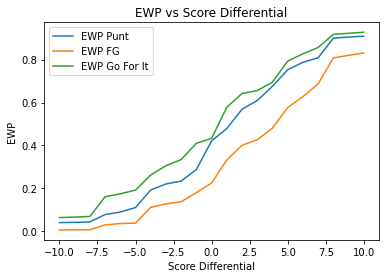

In [262]:
sweep_range = range(-10,11)
df_sweep = sweep_state(base_states[11], sweep_var='score_differential', sweep_values=sweep_range)
x = df_sweep['score_differential'].to_numpy().flatten()
y_punt = df_sweep['ewp_punt'].to_numpy().flatten()
y_fg = df_sweep['ewp_field_goal'].to_numpy().flatten()
y_go = df_sweep['ewp_go_for_it'].to_numpy().flatten()

plt.plot(x, y_punt, label='EWP Punt')
plt.plot(x, y_fg, label='EWP FG')
plt.plot(x, y_go, label='EWP Go For It')
plt.xlabel('Score Differential')
plt.ylabel('EWP')
plt.title('EWP vs Score Differential')
plt.legend()
plt.show()

Brier score: 0.16375
Reliability: 0.00017
Resolution: 0.08563
Uncertainty: 0.24999
Brier check (reliability - resolution + uncertainty): 0.16454


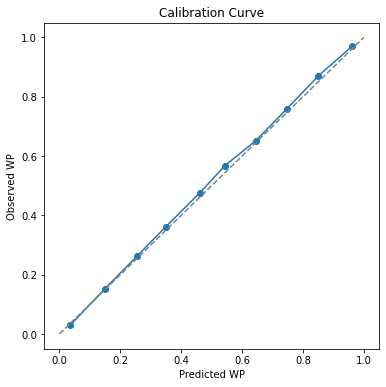

In [263]:
# Compute calibration, Brier score, reliability/resolution
# Bin predicted WP
bins = np.linspace(0, 1, 11)
wp_bin = pd.cut(plays_df['wp_pred'], bins, include_lowest=True)

# Aggregate by bin
cal_table = plays_df.groupby(wp_bin).agg(
    wp_pred_mean=('wp_pred', 'mean'),
    win_rate=('win_actual', 'mean'),
    count=('win_actual', 'count')
).reset_index()

# Brier score
brier = np.mean((plays_df['wp_pred'] - plays_df['win_actual'])**2)

# Reliability and resolution
N = len(plays_df)
reliability = np.sum(cal_table['count'] / N * (cal_table['wp_pred_mean'] - cal_table['win_rate'])**2)
resolution = np.sum(cal_table['count'] / N * (cal_table['win_rate'] - plays_df['win_actual'].mean())**2)
uncertainty = np.mean(plays_df['win_actual']) * (1 - np.mean(plays_df['win_actual']))
brier_check = reliability - resolution + uncertainty

# Print results
print(f"Brier score: {brier:.5f}")
print(f"Reliability: {reliability:.5f}")
print(f"Resolution: {resolution:.5f}")
print(f"Uncertainty: {uncertainty:.5f}")
print(f"Brier check (reliability - resolution + uncertainty): {brier_check:.5f}")

# Plot calibration
x = cal_table['wp_pred_mean'].values.ravel()  # ensures 1D
y = cal_table['win_rate'].values.ravel()     # ensures 1D

plt.figure(figsize=(6,6))
plt.plot(x, y, marker='o')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('Predicted WP')
plt.ylabel('Observed WP')
plt.title('Calibration Curve')
plt.show()

In [264]:
cal_table

,wp_pred,wp_pred_mean,win_rate,count
0,"(-0.001, 0.1]",0.035552,0.029714,40082
1,"(0.1, 0.2]",0.149766,0.152773,26942
2,"(0.2, 0.3]",0.253973,0.261509,26653
3,"(0.3, 0.4]",0.349658,0.361900,33081
4,"(0.4, 0.5]",0.460602,0.475171,43176
5,"(0.5, 0.6]",0.544200,0.568131,37824
6,"(0.6, 0.7]",0.645079,0.651753,35136
7,"(0.7, 0.8]",0.747668,0.759675,28965
8,"(0.8, 0.9]",0.850696,0.870265,24843
9,"(0.9, 1.0]",0.961552,0.970486,35204


In [265]:
bins = np.linspace(0, 1, 11)
calibration_df = pd.DataFrame(index=pd.IntervalIndex.from_tuples([(round(bins[i],2), round(bins[i+1],2)) for i in range(len(bins)-1)]))

# Function to compute empirical win fraction per bin
def empirical_win_fraction(pred_col):
    return pbp_fourth.groupby(pd.cut(pbp_fourth[pred_col], bins=bins))['win_actual'].mean()

# Compute results for each play type
calibration_df['ewp_punt'] = round(empirical_win_fraction('ewp_punt'),3)
calibration_df['ewp_fg'] = round(empirical_win_fraction('ewp_fg'),3)
calibration_df['ewp_go_adj'] = round(empirical_win_fraction('ewp_go_adj'),3)

# Bins indicate predicted wp bin; columns are how often a team actually won in that predicted wp bin
calibration_df

,ewp_punt,ewp_fg,ewp_go_adj
"(0.0, 0.1]",0.036,0.042,0.023
"(0.1, 0.2]",0.136,0.171,0.120
"(0.2, 0.3]",0.260,0.290,0.228
"(0.3, 0.4]",0.376,0.401,0.321
"(0.4, 0.5]",0.424,0.504,0.417
"(0.5, 0.6]",0.526,0.567,0.522
"(0.6, 0.7]",0.665,0.682,0.603
"(0.7, 0.8]",0.745,0.775,0.722
"(0.8, 0.9]",0.874,0.881,0.831
"(0.9, 1.0]",0.969,0.972,0.954


In [266]:
ewp_columns = ['ewp_punt', 'ewp_fg', 'ewp_go_adj']

# Boolean mask of violations
violation_mask = (pbp_fourth[ewp_columns] < 0) | (pbp_fourth[ewp_columns] > 1)

# Count violations per column
violations = violation_mask.sum()

if violations.sum() == 0:
    print("No EWP violations detected.")
else:
    print("Violations detected:")
    print(violations)
    # Show first 5 offending rows for inspection
    print(pbp_fourth[violation_mask.any(axis=1)].head())

No EWP violations detected.


In [267]:
state = pbp_fourth[wp_features]
state_flipped = state.copy()
state_flipped["score_differential"] *= -1
state_flipped[["posteam_timeouts_remaining","defteam_timeouts_remaining"]] = (
    state_flipped[["defteam_timeouts_remaining","posteam_timeouts_remaining"]].values
)
state_flipped["yardline_100"] = 100 - state_flipped["yardline_100"]
state_flipped["score_time_ratio"] = state_flipped["score_differential"].abs() / (state_flipped["game_seconds_remaining"] + 1)

wp = predict_wp(state)
wp_flipped = predict_wp(state_flipped)
flip_err = wp + wp_flipped - 1

flip_err.mean()

0.012789631

In [268]:
# Mean regret
pbp_fourth.regret_actual.mean()

0.013940877166559704

In [269]:
# Compute regret stats by play type ---
regret_by_play = pbp_fourth.groupby('play_type')['regret_actual'].agg(['mean', 'median'])
pbp_fourth['regret_actual'] = pd.to_numeric(pbp_fourth['regret_actual'], errors='coerce')

# Compute stats
regret_by_play = pbp_fourth.groupby('play_type')['regret_actual'].agg(['size', 'mean', 'median'])
regret_by_play['95th'] = pbp_fourth.groupby('play_type')['regret_actual'].quantile(0.95)

print("Regret by Play Type:")
regret_by_play

Regret by Play Type:


,size,mean,median,95th
play_type,,,,
field_goal,8659,0.017937,0.009068,0.058798
pass,3602,0.002708,0.000000,0.013022
punt,18618,0.015727,0.004202,0.058098
run,2091,0.000840,0.000000,0.000006


In [270]:
# Regret vs margin for disagreements
df_disagree = pbp_pre_computed[pbp_pre_computed.disagreed]
disagree_bins = pd.qcut(df_disagree["decision_margin"], q=10, duplicates="drop")
regret_by_margin = df_disagree.groupby(disagree_bins)["regret_actual"].agg(
    mean="mean",
    p95=lambda x: np.percentile(x, 95),
    count="count"
)
print("Regret vs Decision Margin (Disagreements)")
display(regret_by_margin)

# Bin decision margin
pbp_fourth["margin_bin"] = pd.qcut(pbp_fourth["decision_margin"], 10)
follow_by_margin = pbp_fourth.groupby("margin_bin").agg(
    follow_rate=("follow_model", "mean"),
    count=("follow_model", "size")
)
print("Follow Model Rate vs Decision Margin")
follow_by_margin

Regret vs Decision Margin (Disagreements)


,mean,p95,count
decision_margin,,,
"(-0.001, 0.00329]",0.001994,0.005342,1648
"(0.00329, 0.00741]",0.005962,0.008767,1648
"(0.00741, 0.0125]",0.010467,0.012496,1648
"(0.0125, 0.0185]",0.016078,0.018432,1648
"(0.0185, 0.0248]",0.022138,0.024637,1648
"(0.0248, 0.0309]",0.028287,0.030768,1647
"(0.0309, 0.0375]",0.03447,0.037330,1648
"(0.0375, 0.0447]",0.041614,0.044645,1648
"(0.0447, 0.0552]",0.049995,0.054911,1648


Follow Model Rate vs Decision Margin


,follow_rate,count
margin_bin,,
"(-0.001, 0.00333]",0.494389,3297
"(0.00333, 0.00736]",0.511071,3297
"(0.00736, 0.0121]",0.532302,3297
"(0.0121, 0.0179]",0.505914,3297
"(0.0179, 0.0244]",0.490749,3297
"(0.0244, 0.0311]",0.449803,3297
"(0.0311, 0.0387]",0.430695,3297
"(0.0387, 0.0479]",0.415529,3297
"(0.0479, 0.0623]",0.468911,3297


In [271]:
pbp_fourth[(pbp_fourth.decision_margin > .05)].groupby('recommended_play')['regret_actual'].agg(['mean', 'size'])

,mean,size
recommended_play,,
field_goal,0.002850,430
go,0.035428,4065
punt,0.002674,1458


In [285]:
# Base dataset
df = pbp_fourth.copy()

# Keep only real decision play types
df = df[df.play_type.isin(["punt", "field_goal", "run", "pass"])].copy()

# Ensure these exist
ewp_cols = ["ewp_go_adj", "ewp_fg", "ewp_punt"]

# Recommended action + play label
df["best_col"] = df[ewp_cols].idxmax(axis=1)
col_to_play = {"ewp_punt":"punt", "ewp_fg":"field_goal", "ewp_go_adj":"go"}
df["recommended_play"] = df["best_col"].map(col_to_play)

# Decision margin (top - 2nd best)
ewp_sorted = np.sort(df[ewp_cols].to_numpy(), axis=1)
df["decision_margin"] = ewp_sorted[:, -1] - ewp_sorted[:, -2]

# Actual action’s EWP (vectorized, no df.lookup)
action_to_col = {"punt":"ewp_punt", "field_goal":"ewp_fg", "run":"ewp_go_adj", "pass":"ewp_go_adj"}
actual_col = df["play_type"].map(action_to_col)

col_idx = df.columns.get_indexer(actual_col)
row_idx = np.arange(len(df))
df["ewp_actual"] = df.to_numpy()[row_idx, col_idx]

# ewp_best and regret_actual
df["ewp_best"] = df[ewp_cols].max(axis=1)
df["regret_actual"] = df["ewp_best"] - df["ewp_actual"]

# Focus slice: model recommends go
go_slice = df[df["recommended_play"] == "go"].copy()

# Optional: focus on high-confidence go recommendations
go_slice = go_slice[go_slice["decision_margin"] > 0.05].copy()

go_slice[["regret_actual","decision_margin"]].describe()

,decision_margin
count,4065.000000
mean,0.066664
std,0.014575
min,0.050002
25%,0.055846
50%,0.063407
75%,0.073631
max,0.192858


In [293]:
def regret_by_bins(data, feature, bins=None, q=10, right=False, min_count=1):
    """
    If bins is provided -> pd.cut with manual bins.
    Else -> pd.qcut into q quantile bins.
    
    Returns mean_regret, p95_regret, count by bin.
    If a bin has < min_count rows, mean/p95 become NaN.
    """
    s = data[feature]

    if bins is not None:
        b = pd.cut(s, bins=bins, right=right, include_lowest=True)
    else:
        b = pd.qcut(s, q=q, duplicates="drop")

    tmp = data.assign(_bin=b)

    out = (tmp.groupby("_bin")["regret_actual"]
             .agg(
                 mean_regret="mean",
                 p95_regret=lambda x: x.quantile(0.95) if len(x) else np.nan,
                 count="size"
             ))

    # Optional: suppress tiny bins
    if min_count > 1:
        small = out["count"] < min_count
        out.loc[small, ["mean_regret", "p95_regret"]] = np.nan

    return out


yardline_bins = np.array([0,10,20,30,40,50,60,70,80,90,100])
ydstogo_bins  = np.array([0,1,2,3,4,6,8,10,15,25,100])
time_bins     = np.array([0, 60, 120, 300, 600, 900, 1200, 1800, 2700, 3600])  # seconds remaining
half_bins     = np.array([0, 30, 60, 120, 300, 600, 900, 1800])                # half seconds remaining
sd_bins       = np.array([-30,-14,-7,-3,0,3,7,14,30])                          # score differential bins

# if you have possessions_to_tie / scoring_possessions_to_tie in pbp_pre_computed:
poss_bins     = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 10.5])

In [295]:
results_1d = {}

results_1d["by_yardline"] = regret_by_bins(go_slice, "yardline_100", bins=yardline_bins)
results_1d["by_ydstogo"]  = regret_by_bins(go_slice, "ydstogo", bins=ydstogo_bins)
results_1d["by_time"]     = regret_by_bins(go_slice, "game_seconds_remaining", bins=time_bins)
results_1d["by_half"]     = regret_by_bins(go_slice, "half_seconds_remaining", bins=half_bins)
results_1d["by_score"]    = regret_by_bins(go_slice, "score_differential", bins=sd_bins)

# Optional if present:
if "scoring_possessions_to_tie" in go_slice.columns:
    results_1d["by_possessions_to_tie"] = regret_by_bins(go_slice, "scoring_possessions_to_tie", bins=poss_bins)

# Print the main ones
for k in ["by_yardline","by_ydstogo","by_time","by_score"]:
    print("\n", k)
    display(results_1d[k])


 by_yardline


,mean_regret,p95_regret,count
_bin,,,
"[0, 10)",0.033912,0.085012,832
"[10, 20)",0.026846,0.072069,243
"[20, 30)",0.024378,0.070276,247
"[30, 40)",0.019093,0.076593,454
"[40, 50)",0.034171,0.081871,847
"[50, 60)",0.041168,0.079477,650
"[60, 70)",0.046321,0.076674,431
"[70, 80)",0.051908,0.080222,220
"[80, 90)",0.052991,0.076851,125



 by_ydstogo


,mean_regret,p95_regret,count
_bin,,,
"[0, 1)",NaN,NaN,0
"[1, 2)",0.025013,0.081022,2017
"[2, 3)",0.042286,0.080634,850
"[3, 4)",0.045046,0.072408,337
"[4, 6)",0.049948,0.075701,595
"[6, 8)",0.051965,0.073027,235
"[8, 10)",0.02356,0.074523,19
"[10, 15)",0.005051,0.027277,12
"[15, 25)",NaN,NaN,0



 by_time


,mean_regret,p95_regret,count
_bin,,,
"[0, 60)",0.005098,0.057025,50
"[60, 120)",0.023941,0.100771,125
"[120, 300)",0.038215,0.100209,239
"[300, 600)",0.042813,0.087572,230
"[600, 900)",0.040735,0.075528,186
"[900, 1200)",0.039156,0.074394,295
"[1200, 1800)",0.039212,0.078515,590
"[1800, 2700)",0.030006,0.071074,993
"[2700, 3600)",0.036645,0.079479,1357



 by_score


,mean_regret,p95_regret,count
_bin,,,
"[-30, -14)",0.0,0.000000,1
"[-14, -7)",0.01304,0.058181,21
"[-7, -3)",0.027224,0.072317,979
"[-3, 0)",0.035447,0.080035,510
"[0, 3)",0.036306,0.083288,1206
"[3, 7)",0.037826,0.082316,565
"[7, 14)",0.043827,0.077298,717
"[14, 30)",0.03681,0.070779,66
